
## Trial to combine middle ear and bruxism tagging to identify pure moments of middle ear activation

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')

In [21]:
import numpy as np
import mne
from tinnsleep.reports import combine_brux_MEMA, generate_bruxism_report, generate_MEMA_report
from tinnsleep.data import CreateRaw, CleanAnnotations, AnnotateRaw_sliding
from tinnsleep.events.scoring import classif_to_burst, burst_to_episode, episodes_to_list
from tinnsleep.utils import merge_labels_list
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tinnsleep.config import Config
import scipy
print("Config loaded")


Config loaded


## Loading parameters and results

In [5]:


# change to --overwrite True if you want to force to recompute the results
#%run ../compute_results.py --bruxism True --mema True --overwrite False 

#mema_files= pd.read_csv("data/mema_files.csv",engine='python', sep=", ")["files_with_mema"].values

results_MEMA = pd.read_pickle("data/reports_and_datas_MEMA.pk").to_dict()
results_brux = pd.read_pickle("data/reports_and_datas_bruxism.pk").to_dict()
min_burst_joining_brux = 3 
min_burst_joining_MEMA = 0
EDF_list = Config.bruxisme_files[-4:-3]
print(EDF_list)

['F:/Acou_sommeil/EDF_renom\\3KB06_cohort2.edf']


## Bruxism + MEMA processing for pure MEMA visualisation

In [14]:
from time import time
# load file from config

ind_THR_brux=0
ind_THR_MEMA = 0

start = time()
results_brux_combine={}
results_brux_pure={}
results_MEMA_combine={}
results_MEMA_pure={}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    print("Files processed : ")
    
    #Loop on all the patient files
    for filename in EDF_list:
        #opens the raw file
        file = filename.split(os.path.sep)[-1]
        print(file, end=" ")
        if not (file in results_brux.keys() and file in results_MEMA.keys()):
            #print(results_brux[file]["parameters"]["time_interval"])
            print(f"(does not have both bruxism and mema)... skipping")
        else:
            window_length_brux = results_brux[file]["parameters"]["time_interval"]
            delim_brux = results_brux[file]["parameters"]["delim"]
            window_length_MEMA = results_MEMA[file]["parameters"]["time_interval"]
            delim_MEMA = results_MEMA[file]["parameters"]["delim"]
            params_combine = dict(
                                labels_brux = results_brux[file]["labels"][ind_THR_brux], 
                                time_interval_brux = results_brux[file]["parameters"]["time_interval"], 
                                delim_ep_brux = results_brux[file]["parameters"]["delim"], 
                                labels_MEMA = results_MEMA[file]["labels"][ind_THR_MEMA],
                                time_interval_MEMA = results_MEMA[file]["parameters"]["time_interval"],
                                delim_ep_MEMA = results_brux[file]["parameters"]["delim"],
                                min_burst_joining_brux=min_burst_joining_brux, 
                                min_burst_joining_MEMA=min_burst_joining_MEMA
                                )
            print(results_MEMA[file]["parameters"]["time_interval"])
            print(len(results_brux[file]["labels"][0]))
            print(np.sum(results_brux[file]["labels"][0]))
            print(results_brux[file]["reports"][0])
            print(len(results_MEMA[file]["labels"][0])*4)
            print(results_brux[file]["parameters"]["time_interval"])
            
            brux_comb_ep, brux_pure_ep, MEMA_comb_ep, MEMA_pure_ep = combine_brux_MEMA(**params_combine)
            valid_labels_MEMA= results_MEMA[file]["parameters"]["valid_labels"]
            valid_labels_brux= results_brux[file]["parameters"]["valid_labels"]
            #LIGNE IMPORTANTE A CONSERVER
            valid_labels_MEMA = merge_labels_list([valid_labels_MEMA], len(valid_labels_brux))

            
            results_brux_combine[file]= { "THR_classif": [results_brux[file]["THR_classif"][ind_THR_brux]],
                 "labels":  [brux_comb_ep]     ,              
                "reports": [generate_bruxism_report(brux_comb_ep, window_length_brux, delim_brux, valid_labels= valid_labels_brux, min_burst_joining=0)]
                }
            
            results_brux_pure[file]= { "THR_classif": [results_brux[file]["THR_classif"][ind_THR_brux]],
                 "labels":  [brux_pure_ep]     ,              
                "reports": [generate_bruxism_report(brux_pure_ep, window_length_brux, delim_brux, valid_labels= valid_labels_brux, min_burst_joining=0)]
                }
            

            results_MEMA_combine[file]= { "THR_classif": [results_MEMA[file]["THR_classif"][ind_THR_brux]],
                 "labels":  [MEMA_comb_ep]     ,              
                "reports": [generate_MEMA_report(MEMA_comb_ep, window_length_brux, delim_MEMA, valid_labels= valid_labels_MEMA)]}
            
            results_MEMA_pure[file]= { "THR_classif": [results_MEMA[file]["THR_classif"][ind_THR_brux]],
                 "labels": [ MEMA_pure_ep  ]   ,              
                "reports": [generate_MEMA_report(MEMA_pure_ep, window_length_brux, delim_MEMA, valid_labels= valid_labels_MEMA)]}
            
            print("heu")
            print(len(MEMA_comb_ep))
            print(np.sum(brux_comb_ep))
            print(np.sum(brux_pure_ep))
            print(window_length_brux)
            print(delim_brux)
            print(min_burst_joining_brux)
            
            pure_brux_bursts = classif_to_burst(brux_pure_ep, time_interval=window_length_brux)
            li_ep_brux_p = burst_to_episode(pure_brux_bursts, delim=delim_brux, min_burst_joining= 0)#important!!
            pure_brux_events = episodes_to_list(li_ep_brux_p, window_length_brux, len(brux_pure_ep))
            
            comb_brux_bursts = classif_to_burst(brux_comb_ep, time_interval=window_length_brux)
            li_ep_brux_c = burst_to_episode(comb_brux_bursts, delim=delim_brux, min_burst_joining= 0) #Important!!
            comb_brux_events = episodes_to_list(li_ep_brux_c, window_length_brux, len(brux_comb_ep))
            
            comb_MEMA_bursts = classif_to_burst(MEMA_comb_ep, time_interval=window_length_brux) # window_length_brux is valid ?
            
            pure_MEMA_bursts = classif_to_burst(MEMA_pure_ep, time_interval=window_length_brux) # window_length_brux is valid ?
            
            print("rapport d'activité : ")
            print("nb episodes bruxisme combinés : ")
            print(len(li_ep_brux_c))
            print("Nb épisodes bruxisme purs : ")
            print(len(li_ep_brux_p))
            print("nb episodes MEMA combinés : ")
            print(len(comb_MEMA_bursts))
            print("Nb épisodes MEMA purs : ")
            print(len(pure_MEMA_bursts))

            
            print("rapport d'activité taux horaire : ")
            print("nb episodes bruxisme combinés : ")
            print(len(li_ep_brux_c)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
            print("Nb épisodes bruxisme purs : ")
            print(len(li_ep_brux_p)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
            print("nb episodes MEMA combinés : ")
            print(len(comb_MEMA_bursts)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
            print("Nb épisodes MEMA purs : ")
            print(len(pure_MEMA_bursts)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
            
            new_l_comb=[]
            for i in range(len(MEMA_comb_ep)):
                if MEMA_comb_ep[i]:
                    new_l_comb.append(3)
                else:
                    new_l_comb.append(0)
                    
            new_l_pure=[]
            for i in range(len(MEMA_pure_ep)):
                if MEMA_pure_ep[i]:
                    new_l_pure.append(2)
                else:
                    new_l_pure.append(0)
                    
            for i in range(len(comb_brux_events)):
                if comb_brux_events[i]>0:
                    comb_brux_events[i]=4
                    
            for i in range(len(pure_brux_events)):
                if pure_brux_events[i]>0:
                    pure_brux_events[i]=5
                    
            plt.figure()
            plt.plot(pure_brux_events, label="pure_brux")
            plt.plot(comb_brux_events, label="comb_brux")
            plt.plot(new_l_comb, label="comb_MEMA")
            plt.plot(new_l_pure, label="pure_MEMA")
            plt.legend()
            plt.title("Where the events happen for " + file)


#pd.DataFrame.from_dict(results_brux_combine).to_pickle("data/reports_and_datas_bruxism_combine.pk", protocol=3)
#pd.DataFrame.from_dict(results_brux_pure).to_pickle("data/reports_and_datas_bruxism_pure.pk", protocol=3)
#pd.DataFrame.from_dict(results_MEMA_combine).to_pickle("data/reports_and_datas_MEMA_combine.pk", protocol=3)
#pd.DataFrame.from_dict(results_MEMA_pure).to_pickle("data/reports_and_datas_MEMA_pure.pk", protocol=3)
#print("results saved!!")

Files processed : 
3KB06_cohort2.edf 0.992
140480
4134
{'Clean data duration': 14252.064, 'Total burst duration': 1025.232, 'Total number of burst': 934, 'Number of bursts per hour': 235.92372304811428, 'bruxism episode NREM count': 120, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 120, 'Number of bursts per episode': 7.783333333333333, 'Number of episodes per hour': 30.311399106824105, 'Number of tonic episodes per hour': 8.083039761819762, 'Number of phasic episodes per hour': 2.1925245353936105, 'Number of mixed episodes per hour': 3.320108582167467, 'Mean duration of tonic episode': 5.192500000000209, 'Mean duration of phasic episode': 5.973257142857165, 'Mean duration of mixed episode': 15.778415094339671, 'End count': 24, 'End ratio': 0.00017084282460136675, 'NREM count': 67136, 'NREM ratio': 0.47790432801822325, 'Wake count': 73223, 'Wake ratio': 0.5212343394077449, 'start count': 97, 'start ratio': 0.0006904897494305239, 'Power Ratio': array([41.73522675])}
14

C:\Users\Zeta\Anaconda3\lib\site-packages\ipykernel\eventloops.py:106: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.exec_()


## Display of the last computed recording

In [15]:
raw  = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading
duration_brux = int(results_brux[file]["parameters"]["time_interval"] * raw.info['sfreq'])  
interval_brux=duration_brux
print(duration_brux)

#print(new_l_comb)

#print(len(raw))
#-----------------Pure MEMA episodes visualisation and comparison with ATM activity -----------------------------------
#Preparing raw for visualisation
picks_chan = ['Mask Pressure', '1', '2', "Activity"]           # subset of EMG electrodes

print(raw.info["sfreq"])

raw  = CreateRaw(raw[picks_chan][0], raw.info["sfreq"], picks_chan, ch_types=['misc','emg','emg', "misc"])        # pick channels and load
print(len(raw))
scalings = dict(misc=1, emg=1e-5)

raw  = raw.filter(20., 99., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=['1', '2'])
#Annotating the raw
raw = CleanAnnotations(raw)
dict_annotations = {1: "b_pure", 2:"M_pure", 3:"M_comb", 4:"b_comb"}
#raw = AnnotateRaw_sliding(raw, results_brux[file]["labels"][ind_THR_brux][1:-1] , 
#                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)
raw = AnnotateRaw_sliding(raw, new_l_pure[1:-1] , 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)

raw = AnnotateRaw_sliding(raw,  pure_brux_events[1:-1], 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)
raw = AnnotateRaw_sliding(raw, comb_brux_events[1:-1] , 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)
raw = AnnotateRaw_sliding(raw, new_l_comb[1:-1], 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)


print("Raw annotated")
scalings = {'emg': 5e-5, 'misc': 0.2, 'bio':1e3}
raw.plot(scalings = scalings)
plt.title(filename)

<ipython-input-15-19e6e5c6232f>:1: RuntimeWarning: 7 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Intensit? lumine', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  raw  = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading


62
250.0
8710000
Raw annotated


Text(0.5, 1, 'F:/Acou_sommeil/EDF_renom\\3KB06_cohort2.edf')

## Analysis 

In [22]:
#Here replace with the metric to analyse
info_file = "data/data_info.csv"
print(os.getcwd())
results_file = "data/reports_and_datas_MEMA_pure.pk"
results = pd.read_pickle(results_file).to_dict()
THR_classif = results[list(results.keys())[0]]["THR_classif"]

THR_classif = np.array(results[list(results.keys())[0]]["THR_classif"])

data_info = pd.read_csv(info_file, sep=",").query('mema == 1 & included == 1 & session == "1" & emg==1 ')
#data_info = pd.read_csv(info_file, sep=",").query('mema == 1 & included == 1 & emg==1 ')
#data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & included == 1 & subject == "1SL21" & session != "6" ')

print(f"Valid files for mema pure {data_info.shape[0]}")
print(data_info[["filename", "condition"]])
results_updated = dict()
for filename in results.keys():
    if filename in data_info["filename"].values:
        if not filename == "3CL02_cohort2.edf":
            if not filename == "1CB23_cohort2.edf":
                if not filename == "3TS03_cohort2.edf":
                    if not filename == "2GA06_nuit_1.edf":
                       #if not filename == "1GF14_cohort2.edf":
                            results_updated[filename] = results[filename]
results = results_updated
print(len(results_updated.keys()))

C:\Users\Zeta\Documents\acou_sommeil_HD_ENS\Tinnitus-n-Sleep\notebooks
Valid files for mema pure 26
              filename    condition
4   1DA15_nuit_hab.edf  habituation
9   1GB18_nuit_hab.edf  habituation
28    1HB20_nuit_1.edf  habituation
36    1SL21_nuit_2.edf  habituation
40    1UC22_nuit_1.edf  habituation
42    2GA06_nuit_1.edf      control
43    2SJ03_nuit_1.edf      control
49    2LS05_nuit_1.edf      control
50    2CT04_nuit_1.edf      control
57   1ZN04_cohort2.edf       batch2
58   1HS25_cohort2.edf       batch2
59   1PA31_cohort2.edf       batch2
60   3NS01_cohort2.edf       batch2
61   1CB23_cohort2.edf       batch2
62   1RF29_cohort2.edf       batch2
63   1GF14_cohort2.edf       batch2
64   1DM32_cohort2.edf       batch2
65   3BS04_cohort2.edf       batch2
66   3TR07_cohort2.edf       batch2
67   3KB06_cohort2.edf       batch2
68   1NS30_cohort2.edf       batch2
69   1AC26_cohort2.edf       batch2
70   3CL02_cohort2.edf       batch2
71   3TS03_cohort2.edf       batch2


In [23]:
get_scores=[]
for elm in results.keys():
        print (elm)
        l_ep_h=[]
        for ep in results[elm]["reports"]:
            print(ep["Number of MEMA episodes per hour"])
            
            l_ep_h.append(ep["Number of MEMA episodes per hour"])
        print(ep.keys())

        get_scores.append([elm.split(os.path.sep)[-1], l_ep_h])
print(len(get_scores))
print(get_scores)

1AC26_cohort2.edf
9.501177728404135
dict_keys(['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode'])
1DA15_nuit_hab.edf
5.504587155963303
dict_keys(['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode'])
1DM32_cohort2.edf
8.594510972325674
dict_keys(['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode'])
1GB18_nuit_hab.edf
15.504558314995284
dict_keys(['Clean MEMA duration', 'Total MEMA burst 

In [24]:
# format reports
reports = None
for filename in results.keys():
    report = pd.DataFrame(results[filename]["reports"])
    report["THR_classif"] = THR_classif[:,1]
    report["filename"] = filename
    if reports is None:
        reports = report
    else:
        reports = reports.append(report, ignore_index=True)

        
import math     
def map_category(x):
    if x < (-0.1):
        return "decrease"
    elif x > (0.1):
        return "increase"
    elif math.isnan(x):
        return "control"
    else:
        return "stable"
#putting away damaged recordings
data_info["category"] = data_info["mask_per"].apply(map_category)



reports = reports.merge(data_info, on="filename")

In [25]:
##Preparing values for correlation scatter plots
    
print("Nb_patients in each group : ")
for category in list(data_info['category'].unique()):
    print(f"Tinnitus {category} : {(data_info['category']==category).sum()}, {(list(data_info[data_info['category']==category]['subject']))}")

report_mean = reports.groupby(['category', 'THR_classif']).mean()
report_std =  reports.groupby(['category', 'THR_classif']).std()

Nb_patients in each group : 
Tinnitus stable : 7, ['1DA15', '1GB18', '1SL21', '1PA31', '1CB23', '1RF29', '3KB06']
Tinnitus decrease : 7, ['1HB20', '1ZN04', '3NS01', '3BS04', '3TR07', '3CL02', '3HS08']
Tinnitus increase : 7, ['1UC22', '1HS25', '1GF14', '1DM32', '1NS30', '1AC26', '3TS03']
Tinnitus control : 5, ['2GA06', '2SJ03', '2LS05', '2CT04', '2TL07']


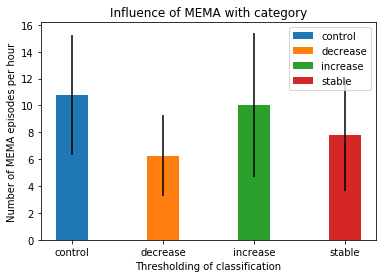

In [26]:
#Displaying
plt.figure()
value = "Number of MEMA episodes per hour"
width = 0.35
for category in list(report_mean.index.get_level_values(0).unique()):
    plt.bar(category, report_mean.loc[category][value], width, yerr = report_std.loc[category][value], label = category)
plt.title("Influence of MEMA with category" )
plt.xlabel('Thresholding of classification')
plt.ylabel(value)
plt.legend()

In [27]:
l=[]
for i in range(4):
    print(list(reports.groupby(['category', 'THR_classif']))[i][0])
    print(list(list(reports.groupby(['category', 'THR_classif']))[i][1]["Number of MEMA episodes per hour"]))
    l.append(list(list(reports.groupby(['category', 'THR_classif']))[i][1]["Number of MEMA episodes per hour"]))
print(scipy.stats.ttest_ind(l[0], l[2]))
print(scipy.stats.ttest_ind(l[1], l[2]))
print(scipy.stats.ttest_ind(l[3], l[2]))

('control', 3)
[11.12106691270311, 16.932827741125998, 8.230552380518033, 6.779617242180841]
('decrease', 3)
[3.3768352365415986, 11.441043205921005, 5.508435894669577, 5.665266309481481, 5.331047603119186]
('increase', 3)
[9.501177728404135, 8.594510972325674, 2.778940979410547, 9.802308019982187, 9.975566994108162, 19.52258835778879]
('stable', 3)
[5.504587155963303, 15.504558314995284, 5.353171791461245, 4.2777851054652265, 9.33968138164391, 6.716602983319862]
Ttest_indResult(statistic=0.2251921655617872, pvalue=0.8274756824331194)
Ttest_indResult(statistic=-1.3824582472448477, pvalue=0.20016898359270394)
Ttest_indResult(statistic=-0.8084336465369789, pvalue=0.43765078702874194)


In [28]:
quantitative_variables = list(results[list(results.keys())[0]]["reports"][0].keys()) #(remove power ratio a sleep analysis)
print(f'variables: {quantitative_variables}')
effect_variable = ["mask_delta", "mask_per", "VAS_I_delta", "VAS_I_per", "VAS_L_delta", "VAS_L_per"]
#reports["Power Ratio"] = reports["Power Ratio"].apply(sum)

variables: ['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode']


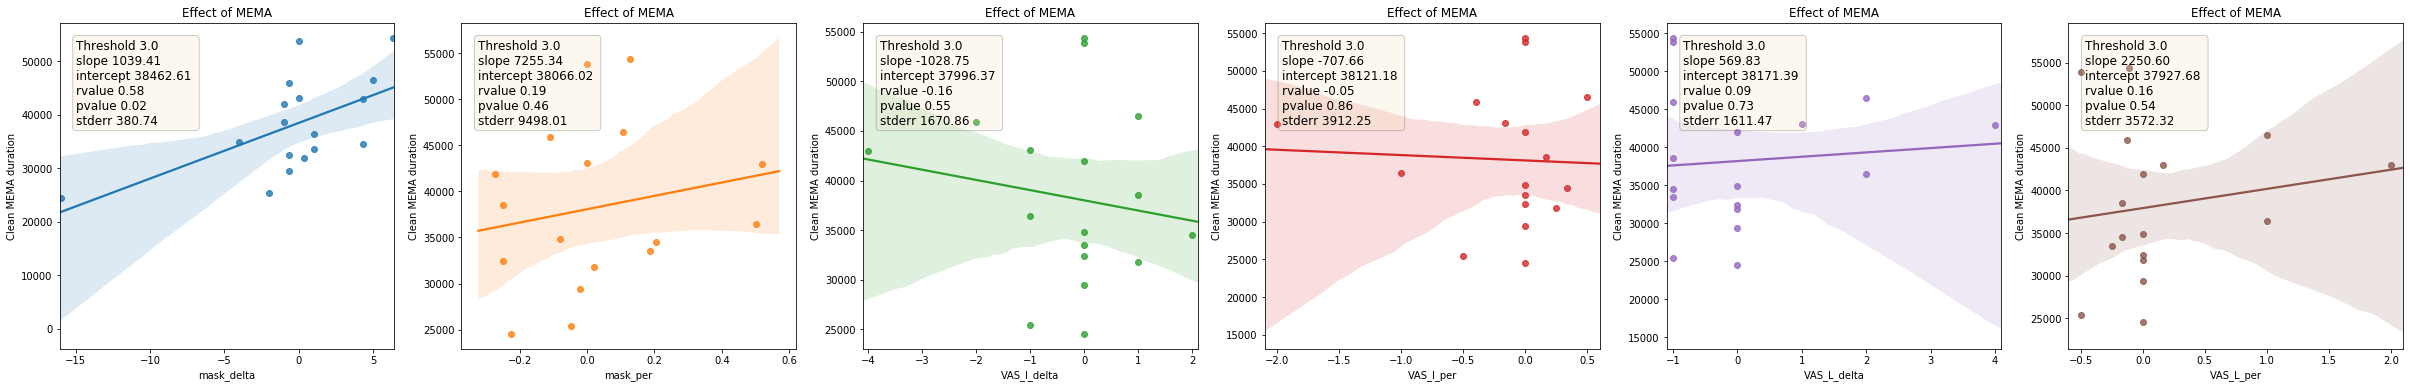

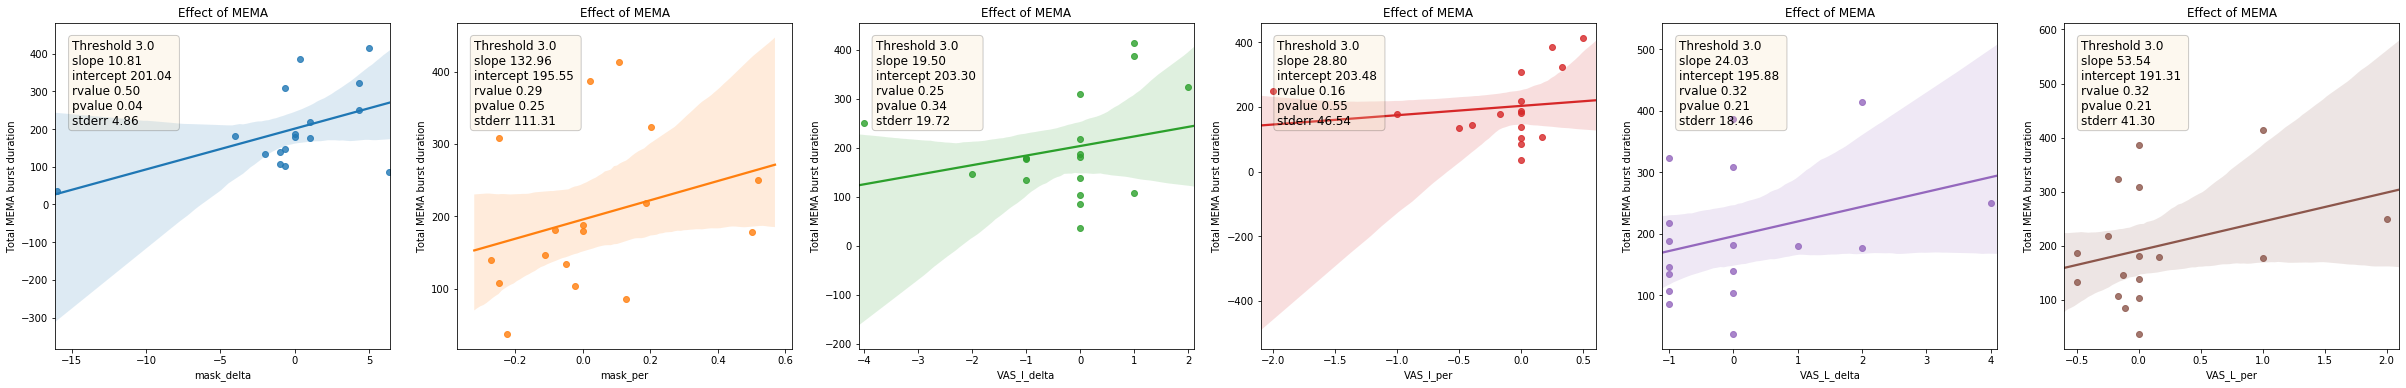

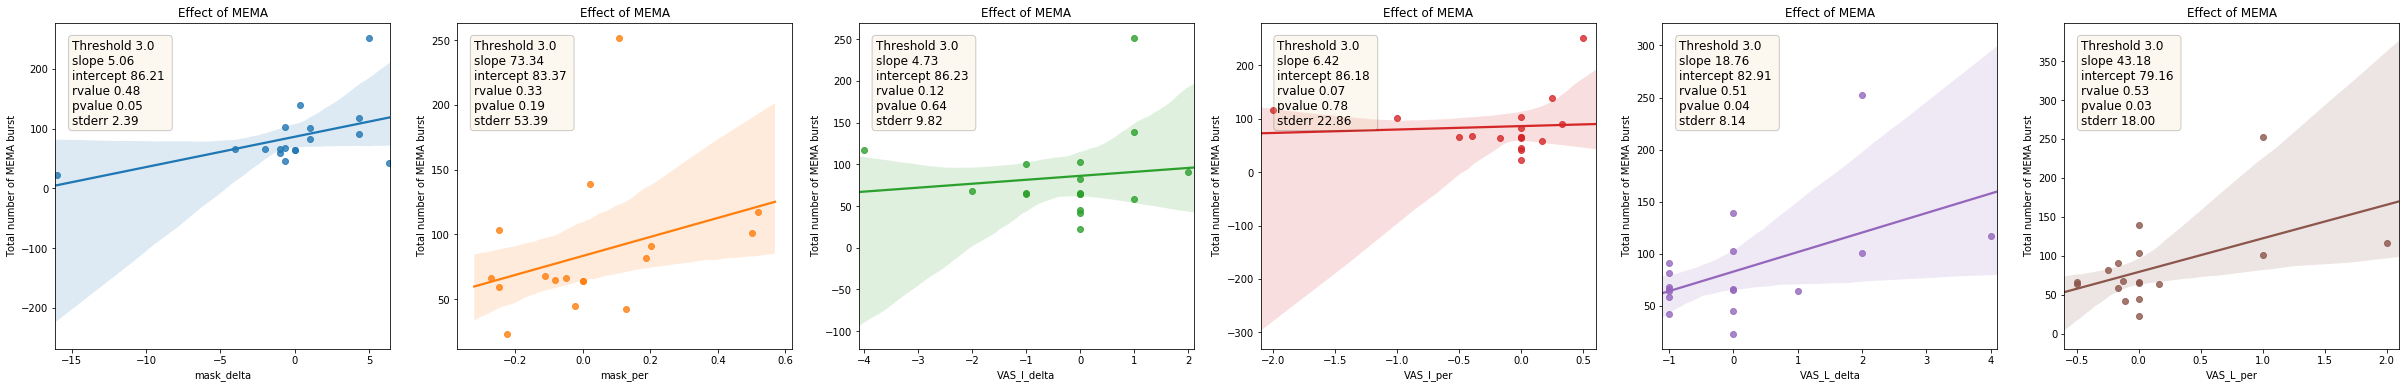

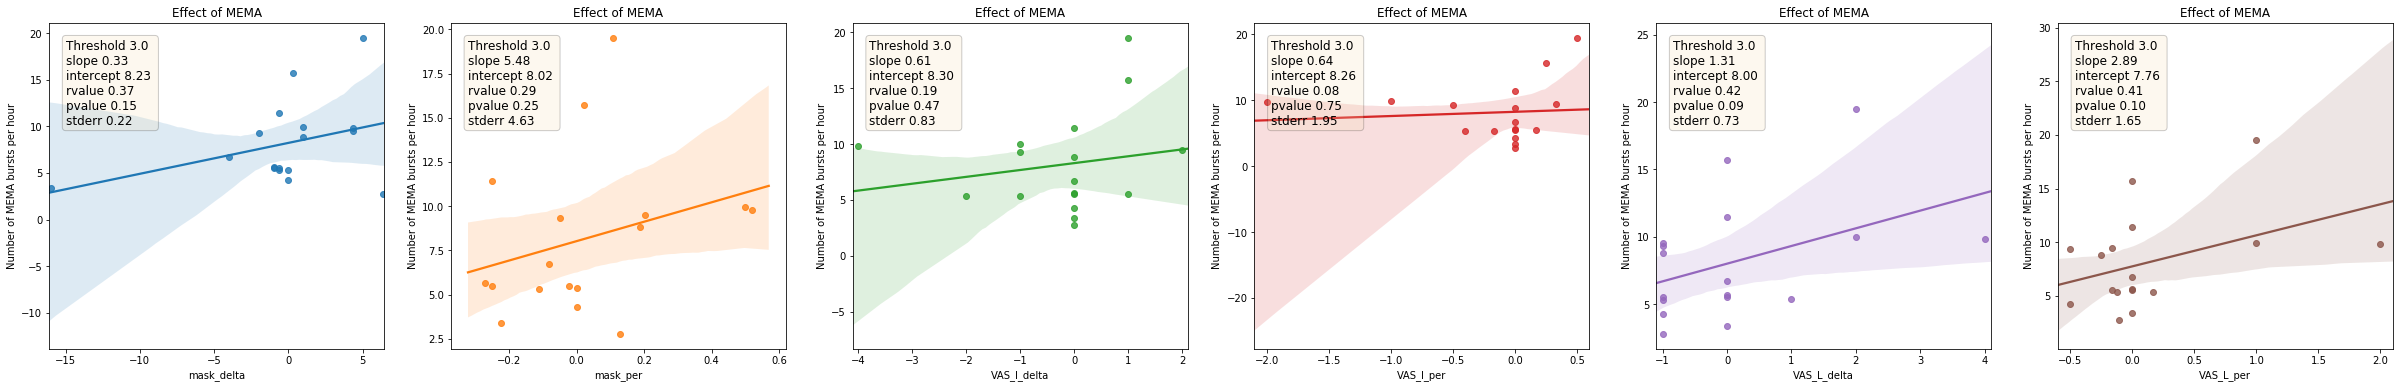

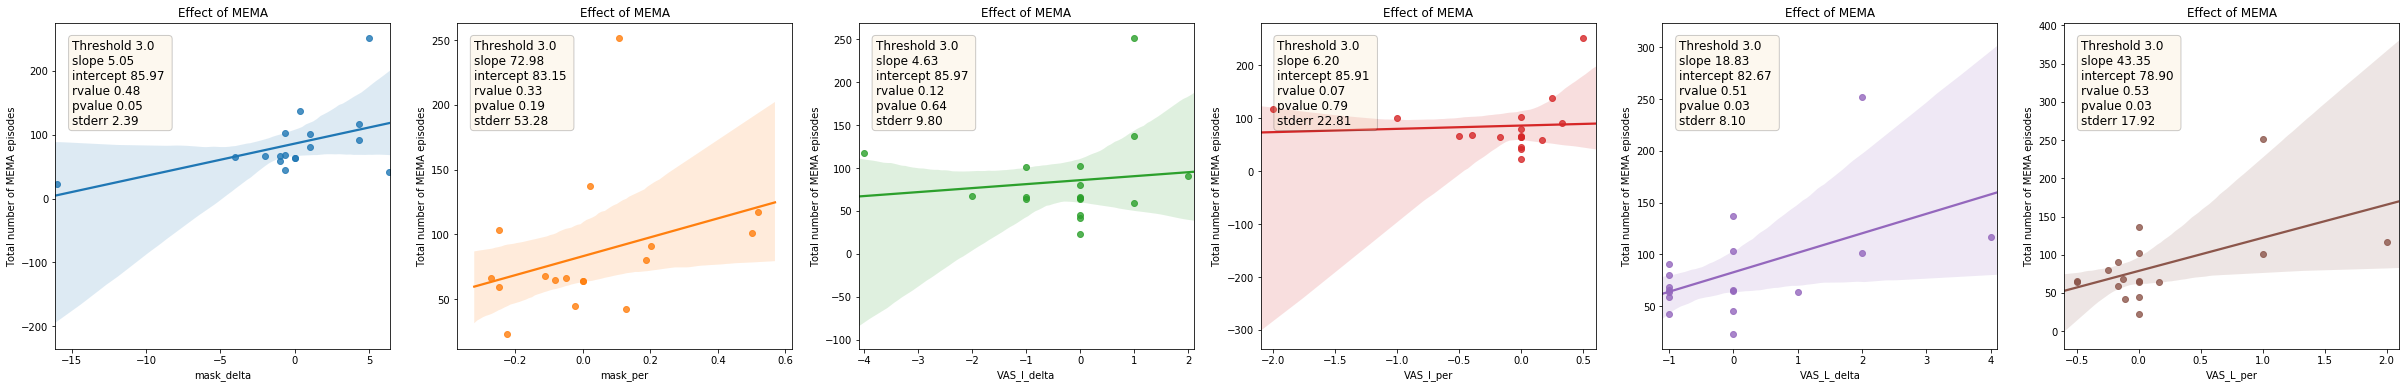

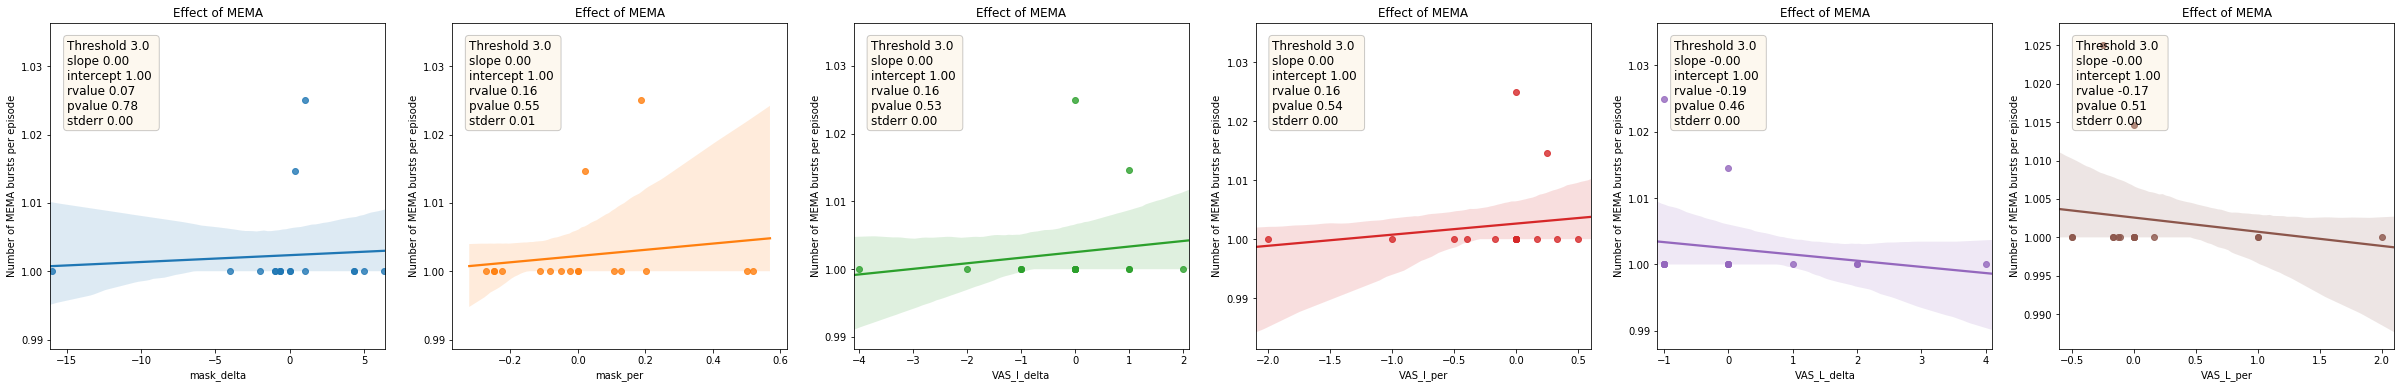

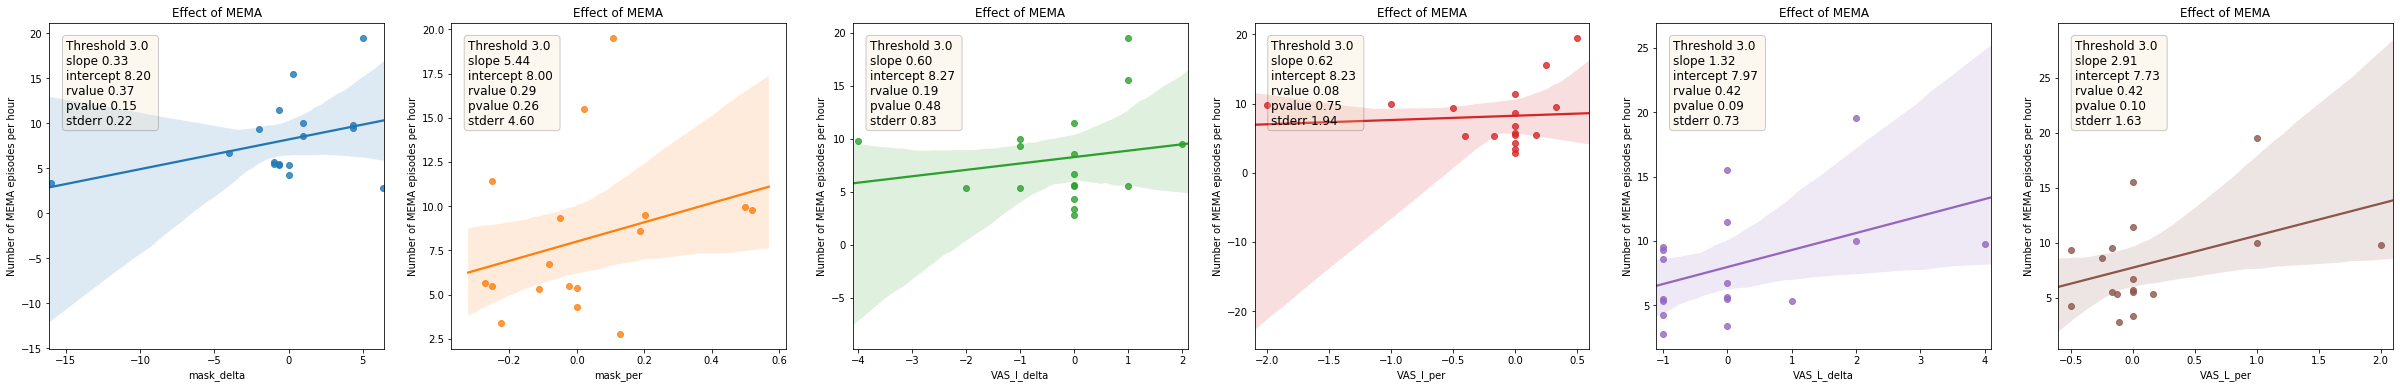

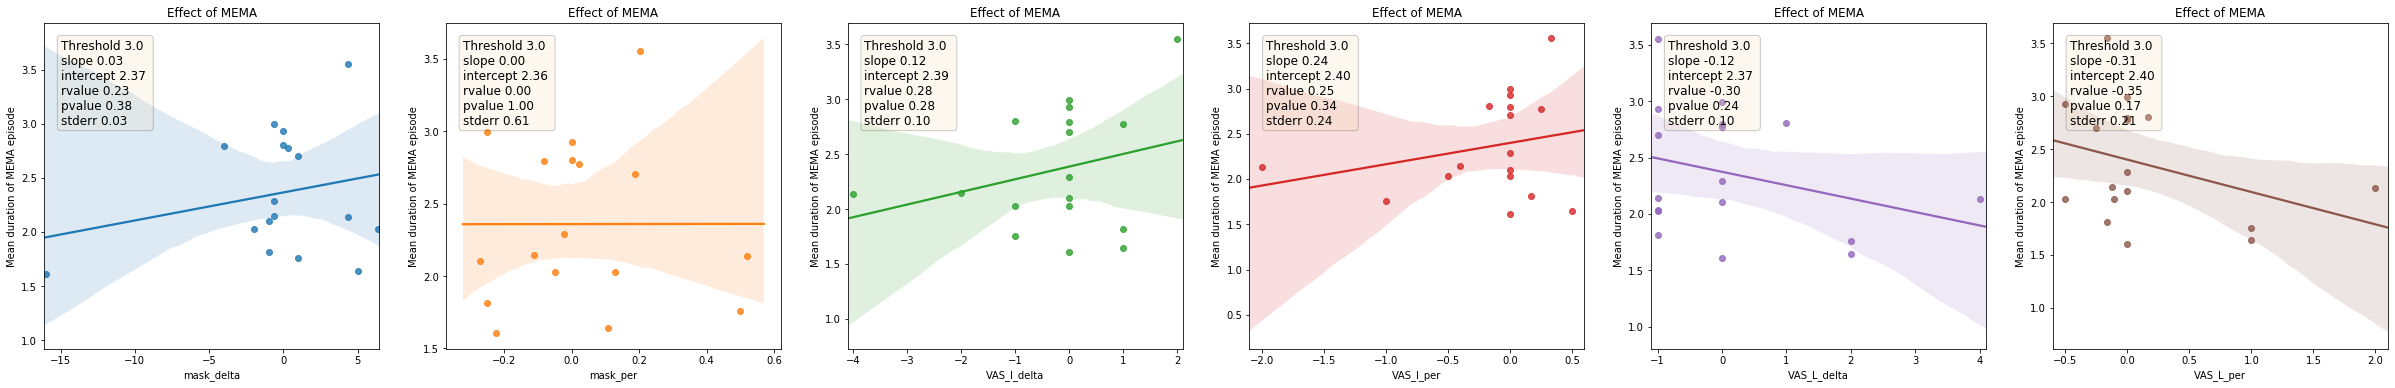

In [29]:
meta_results = pd.DataFrame()
import seaborn as sns
plt.close("all")
data = reports.query("category != 'control'")
# loop over all quantitative variables (y_axis)
for y_axis in quantitative_variables:
    # loop on all classification results (each figure)
    for threshold in reports["THR_classif"].unique():
        data_loc = data[data["THR_classif"]==threshold]
        f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 6))
        # loop on all effect variables (each subplot)
        for x_axis, ax in zip(effect_variable, axes):
            sns.regplot(x=x_axis,y=y_axis,data=data_loc,fit_reg=True, ax=ax)
            ax.set_xlim(min(data_loc[x_axis].values)-0.1,max(data_loc[x_axis].values)+0.1)
            regression_result = scipy.stats.linregress(data_loc[x_axis].values,data_loc[y_axis].values)
            tmp = {"x_axis":x_axis, "y_axis":y_axis, "THR_classif": [threshold]}
            textstr = f"Threshold {threshold:.1f} "
            for a, re in zip(regression_result._fields, regression_result):
                textstr = textstr + "\n" + f"{a} {re:.2f} "
                tmp[a] = [re]
            ax.set_title("Effect of MEMA")
            # place patch
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                    verticalalignment='top', bbox=props)
            
            # save results
            meta_results = pd.concat([meta_results, pd.DataFrame(tmp)])

In [30]:
meta_results.query("pvalue < 0.05")

,x_axis,y_axis,THR_classif,slope,intercept,rvalue,pvalue,stderr
0,mask_delta,Clean MEMA duration,3,1039.411682,38462.613185,0.576135,0.015498,380.739359
0,mask_delta,Total MEMA burst duration,3,10.808454,201.037588,0.497901,0.041961,4.860840
0,VAS_L_delta,Total number of MEMA burst,3,18.755556,82.911111,0.511456,0.035864,8.136276
0,VAS_L_per,Total number of MEMA burst,3,43.184586,79.155069,0.526516,0.029908,18.004225
0,VAS_L_delta,Total number of MEMA episodes,3,18.833333,82.666667,0.514759,0.034486,8.098933
0,VAS_L_per,Total number of MEMA episodes,3,43.350308,78.896894,0.529754,0.028733,17.920330


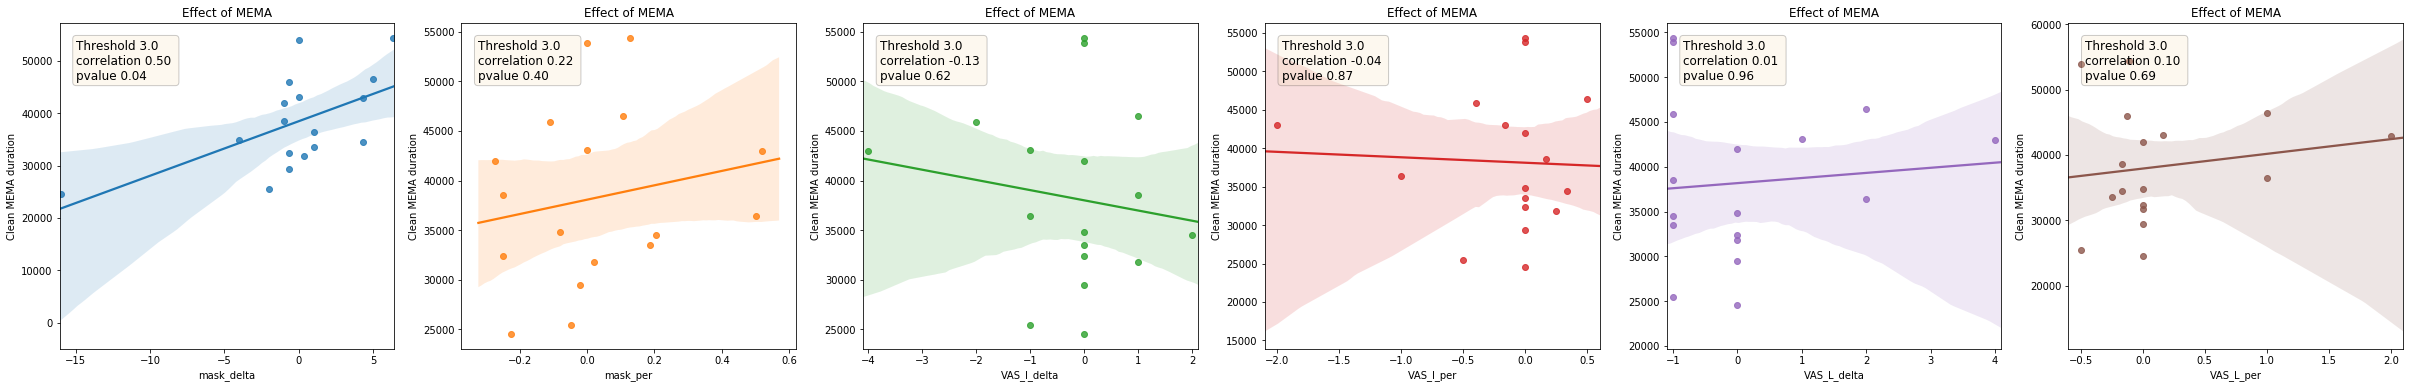

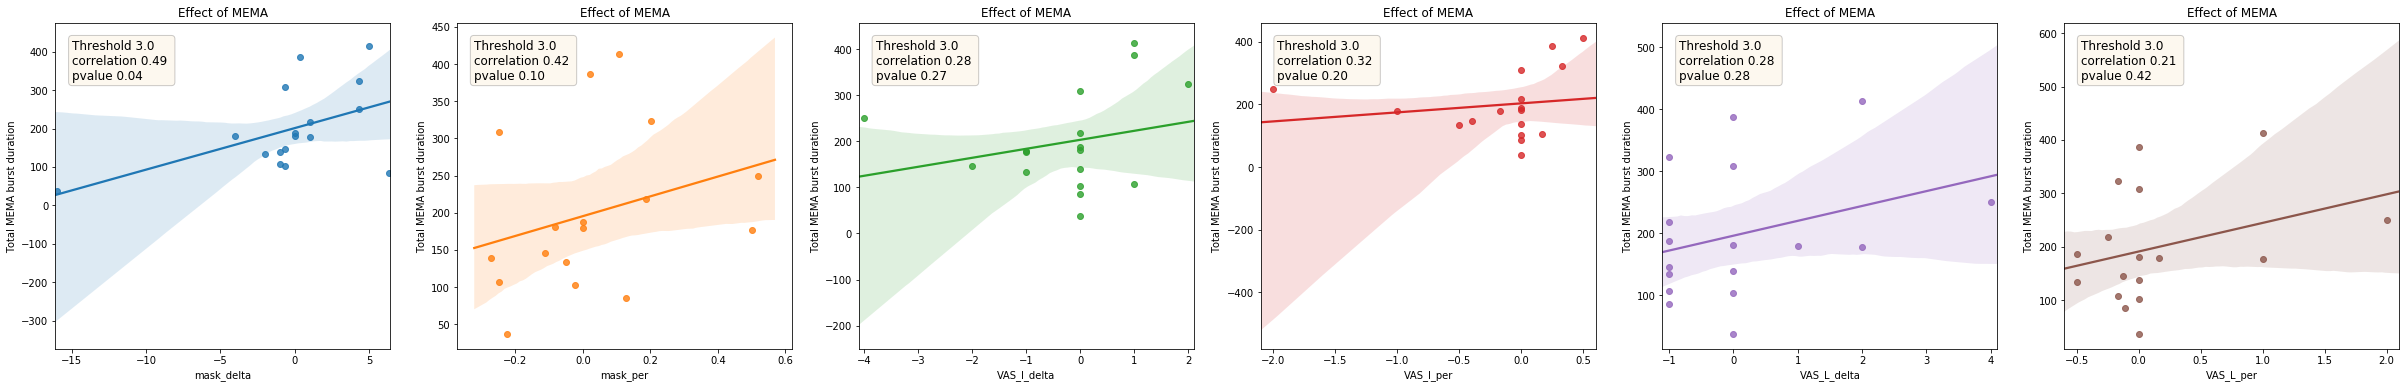

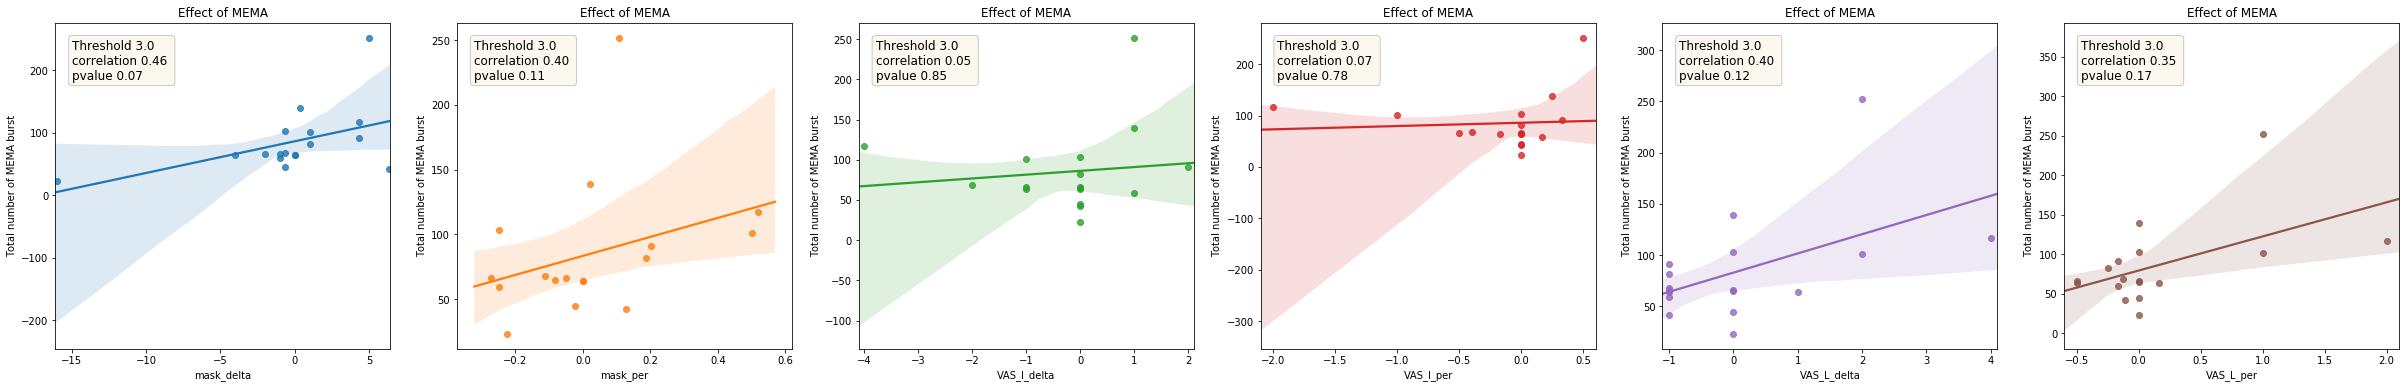

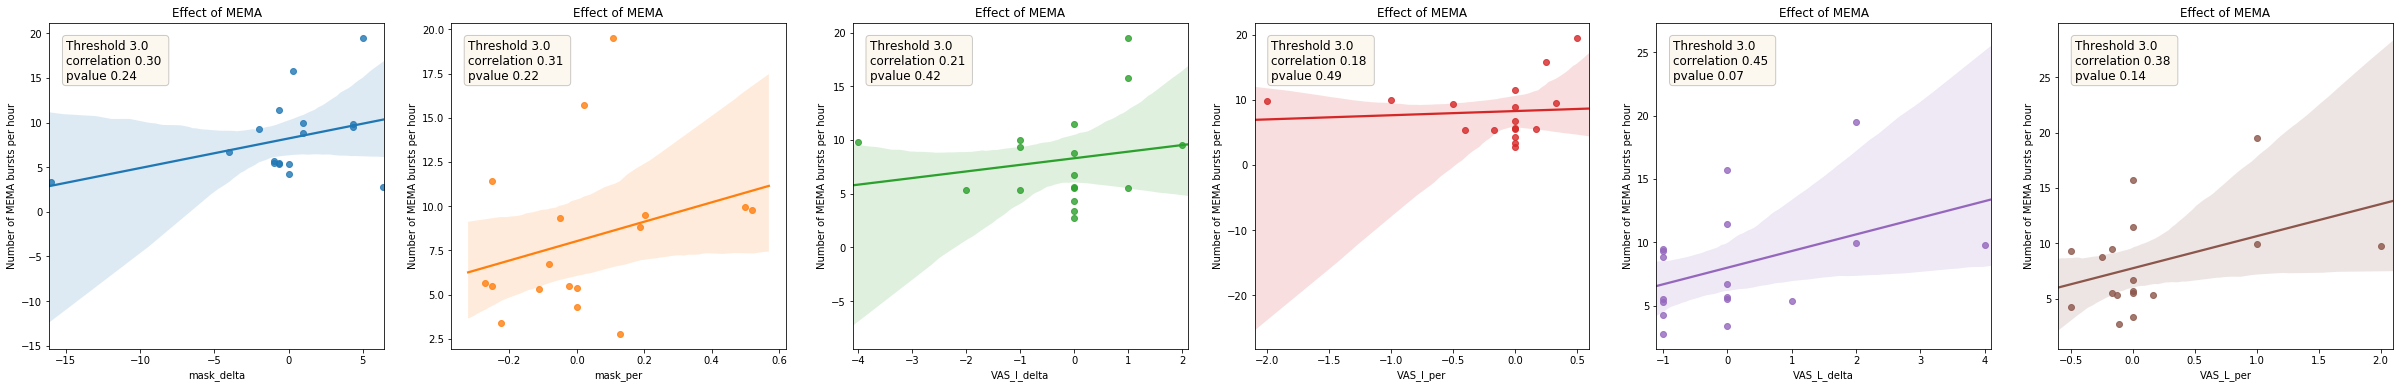

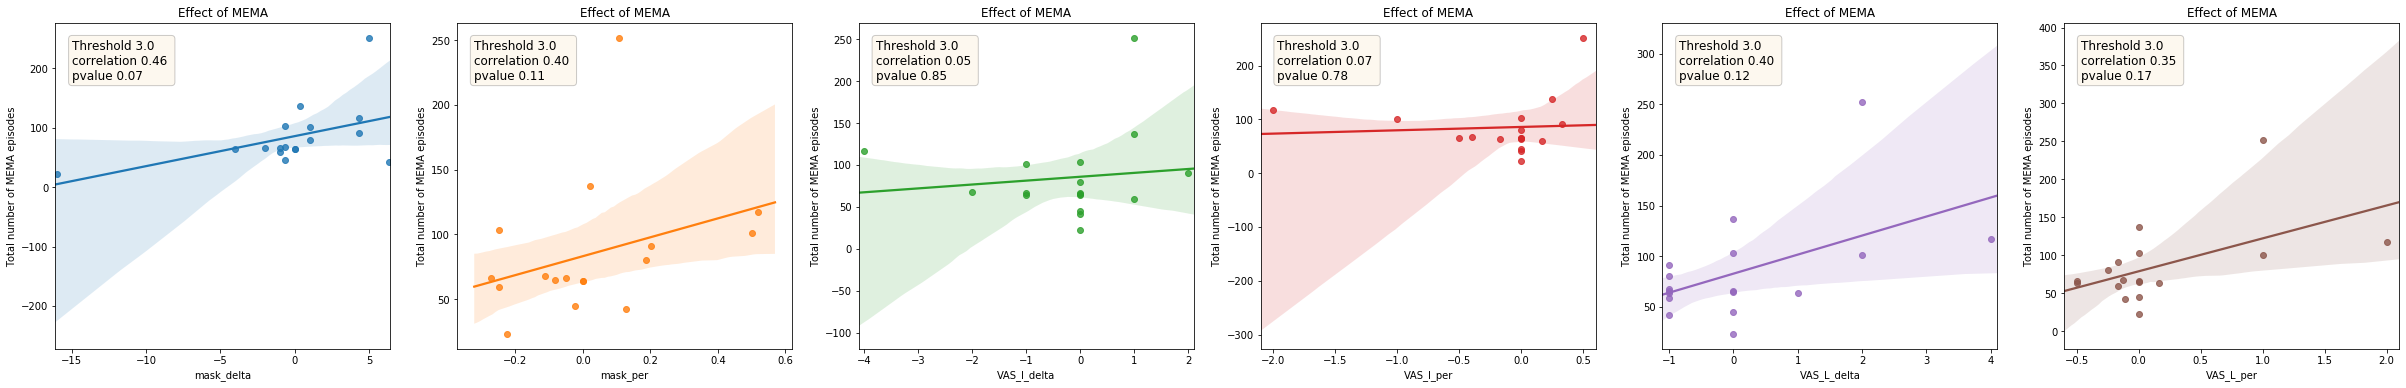

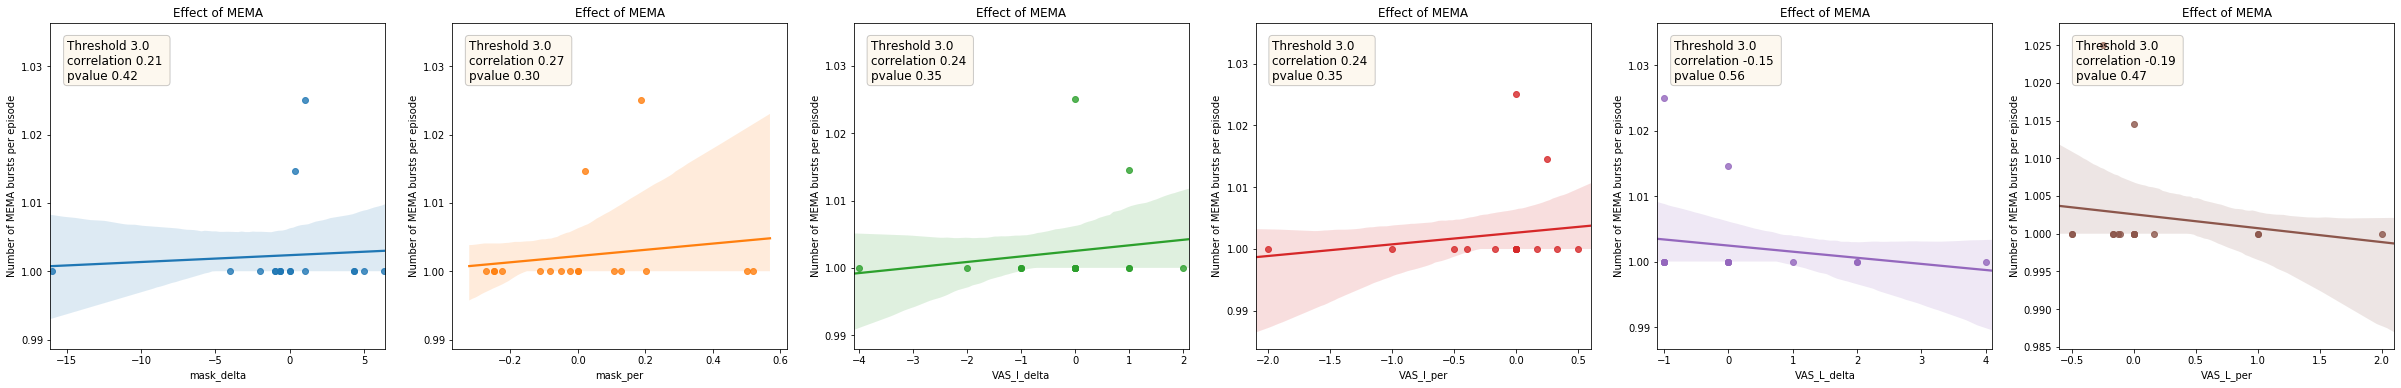

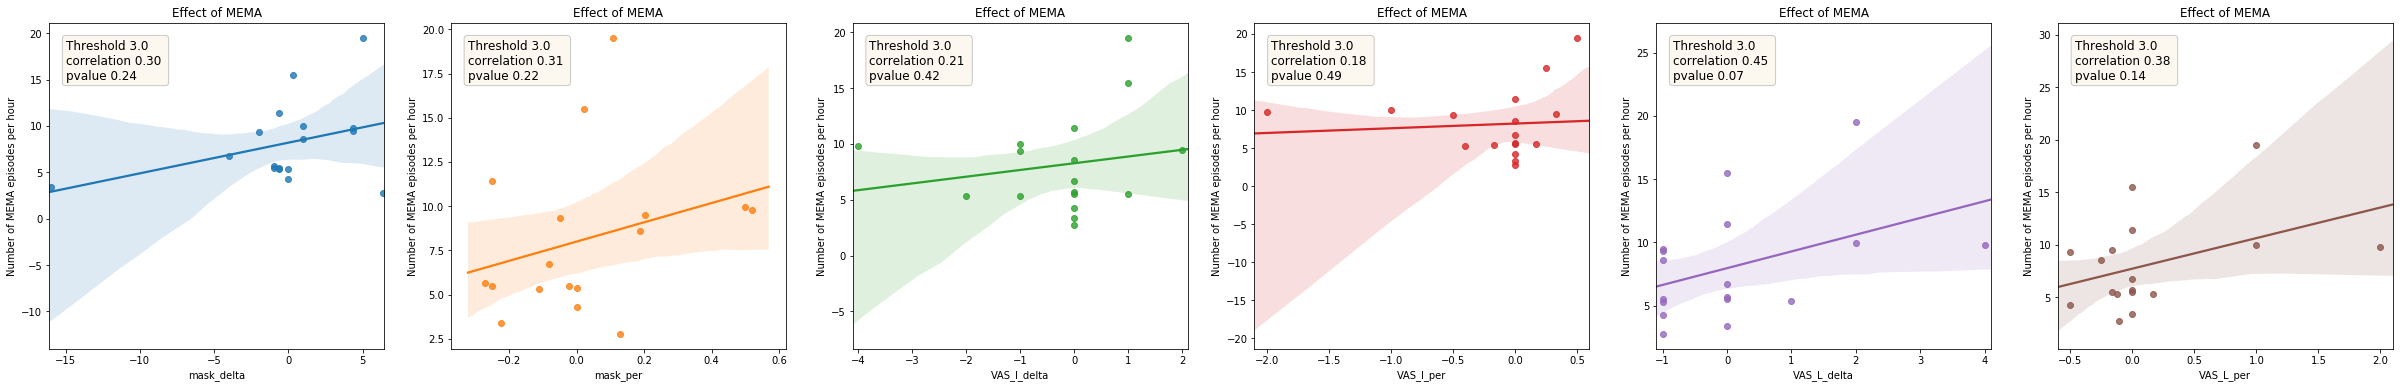

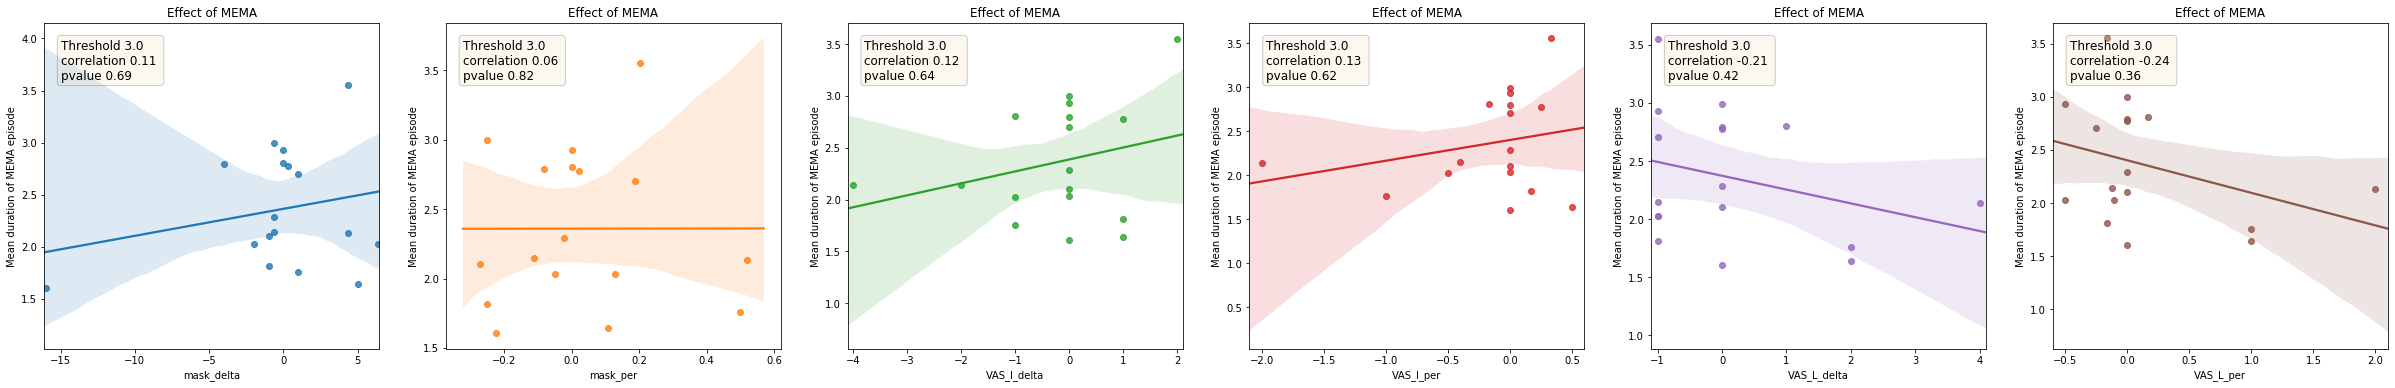

In [31]:
meta_results = pd.DataFrame()
import seaborn as sns
plt.close("all")
data = reports.query("category != 'control'")
# loop over all quantitative variables (y_axis)
for y_axis in quantitative_variables:
    # loop on all classification results (each figure)
    for threshold in reports["THR_classif"].unique():
        data_loc = data[data["THR_classif"]==threshold]
        f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 6))
        # loop on all effect variables (each subplot)
        for x_axis, ax in zip(effect_variable, axes):
            sns.regplot(x=x_axis,y=y_axis,data=data_loc,fit_reg=True, ax=ax)
            ax.set_xlim(min(data_loc[x_axis].values)-0.1,max(data_loc[x_axis].values)+0.1)
            regression_result = scipy.stats.spearmanr(data_loc[x_axis].values,data_loc[y_axis].values)
            tmp = {"x_axis":x_axis, "y_axis":y_axis, "THR_classif": [threshold]}
            textstr = f"Threshold {threshold:.1f} "
            for a, re in zip(regression_result._fields, regression_result):
                textstr = textstr + "\n" + f"{a} {re:.2f} "
                tmp[a] = [re]
            ax.set_title("Effect of MEMA")
            # place patch
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                    verticalalignment='top', bbox=props)
            
            # save results
            meta_results = pd.concat([meta_results, pd.DataFrame(tmp)])

In [32]:
meta_results.query("pvalue < 0.05")

,x_axis,y_axis,THR_classif,correlation,pvalue
0,mask_delta,Clean MEMA duration,3,0.500928,0.040536
0,mask_delta,Total MEMA burst duration,3,0.494774,0.043473
